In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import astropy.units as u
from astropy.io import fits 
from astropy.coordinates import SkyCoord 
from astropy.wcs import WCS
from photutils.aperture import CircularAperture
from photutils import aperture_photometry, SkyCircularAperture
import glob 
from RetrieveSource import *
#import RetrieveSource

In [2]:
# Get Image 
id = 40415
segment = 1
extension = 1
filter ='um2'
# Change where SWIFT data is stored
file_location = "/home/bethany/Desktop/Swift_Astrometry"

# Below is automatic.
labels = ['RAhr','DEdeg','Umag','e_Umag','Bmag','e_Bmag','Vmag','e_Vmag','Imag','e_Imag','Flag','Jmag','e_Jmag','Hmag','e_Hmag','Ksmag','e_Ksmag']

def get_file(id,segment=1,extension=1,filter='um2'):
    fname = glob.glob(f"{file_location}/SMC/sw000{id}00{segment}{filter}_sk_{id}_{segment}_{extension}.new")
    cname = glob.glob(f"{file_location}/SMC/sw000{id}00{segment}{filter}_sk_{id}_{segment}_{extension}.full.dat")
    HDR = fits.open(fname[0])
    CAT = pd.read_csv(cname[0],delimiter='\s+',names=labels)
    return HDR[0],CAT,cname

def get_usno_bright_objects(hdr,df,aperture_size=5):
    # Get SkyCoord positions
    positions = SkyCoord(df['RAJ2000'],df['DEJ2000'],unit=(u.deg))
    # Get Apertures
    apertures = SkyCircularAperture(positions, r = aperture_size * u.arcsec)
    # Convert to Pixel Apertures
    pix_apertures = apertures.to_pixel(WCS(hdr.header))
    # Get Photometry
    photometry = aperture_photometry(hdr.data, pix_apertures)['aperture_sum']
    # Get Count Rate 
    return photometry / hdr.header['EXPOSURE']

def mask_out(x,y,hdr,aperture_size = 12):
    apertures = CircularAperture([(x_,y_) for x_,y_ in zip(x,y)], aperture_size)
    masks = apertures.to_mask(method="center")

    # Create a template of all ones.
    blank_data = np.ones(np.shape(hdr.data))

    # Zero out where the mask is
    for mask in masks:
        new_mask = mask.to_image(np.shape(hdr.data))
        m_x,m_y = np.where(new_mask !=0)
        blank_data[m_x,m_y] = 0

    # Multiply the mask by the data
    masked_data = blank_data * hdr.data 
    
    return masked_data

def remove_usno_bright_objects(hdr,usno_catalog,threshhold = 65): 
    # Read in USNO Catalog
    df = pd.read_csv(usno_catalog,delimiter='\s+')

    # Get the photometry for bright USNO Sources 
    phot = get_usno_bright_objects(hdr,df) 

    # If anything should be filtered
    if len(phot) > 0: 
        # Filter that photometry for valid and above given threshhold (count rate)
        drop_cat = df[(~np.isnan(phot)) & (phot != 0) & (phot > threshhold)]
        x,y =  SkyCoord(drop_cat.RAJ2000,drop_cat.DEJ2000,unit=u.deg).to_pixel(WCS(hdr))
        # Keep track of what is filtered - Add the aperture sum count rate to a catalog
        phot = phot[(~np.isnan(phot)) & (phot != 0) & (phot > threshhold)]
        drop_cat['phot'] = phot
        # Mask out bright usno objects 
        masked_from_usno_im = mask_out(x,y,hdr,aperture_size = 12) 
        return masked_from_usno_im, drop_cat

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55466.000949 from DATE-OBS.
Set MJD-END to 55466.003194 from DATE-END'. [astropy.wcs.wcs]
/home/bethany/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(900, 1200)

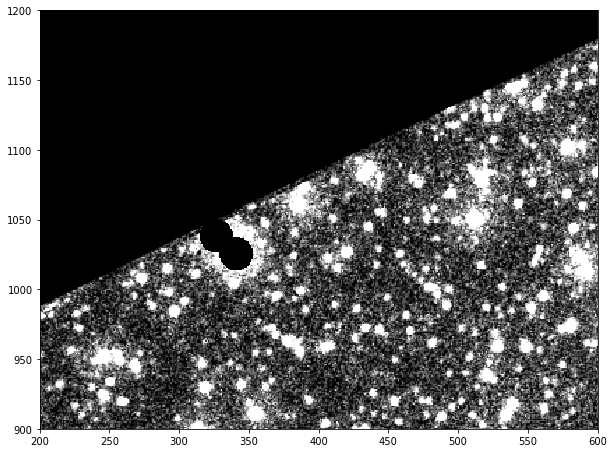

In [3]:
hdr,cat,catname = get_file(id)
im,dcat = remove_usno_bright_objects(hdr,'smc_anti_match_USNO_inf.dat')

plt.figure(figsize=(10,10))

plt.imshow(im,origin='lower',vmin=0,vmax=5,cmap='Greys_r')
plt.xlim(200,600)
plt.ylim(900,1200)

In [4]:
dcat

,UCAC4,RAJ2000,DEJ2000,ePos,f.mag,of,db,pmRA,pmDE,Jmag,...,H,A,b,h,Z,B,L,N,S,phot
20458,088-002983,14.671767,-72.437627,47,11.574,0,0,-3.4,-0.7,11.206,...,3,1,0,0,0,0,0,0,1,68.784840
23085,089-003382,15.320811,-72.291984,16,11.546,3,0,-0.4,-1.8,11.197,...,2,7,0,0,0,0,0,0,1,79.860759
23087,089-003391,15.333913,-72.288385,26,13.646,3,0,-4.9,2.1,13.736,...,2,0,0,0,0,0,0,0,1,72.761832


In [5]:
size = np.shape(hdr.data)

In [6]:
source = get_meta().with_hdu(hdu=hdr,
                 usno_catalog='smc_anti_match_USNO_inf.dat',
                 optical_catalog=catname[0],
                 Umag_cutoff=np.nan,
                 Bmag_cutoff=np.nan,
                 fits_origin=0,
                 aperture_size=2.5*2,
                 xdim=[0,size[1]],
                 ydim=[0,size[0]])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55466.000949 from DATE-OBS.
Set MJD-END to 55466.003194 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55466.000949 from DATE-OBS.
Set MJD-END to 55466.003194 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55466.000949 from DATE-OBS.
Set MJD-END to 55466.003194 from DATE-END'. [astropy.wcs.wcs]


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


/home/bethany/Desktop/SUMS/Tractor/RetrieveSource.py:350: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_cat['phot'] = phot


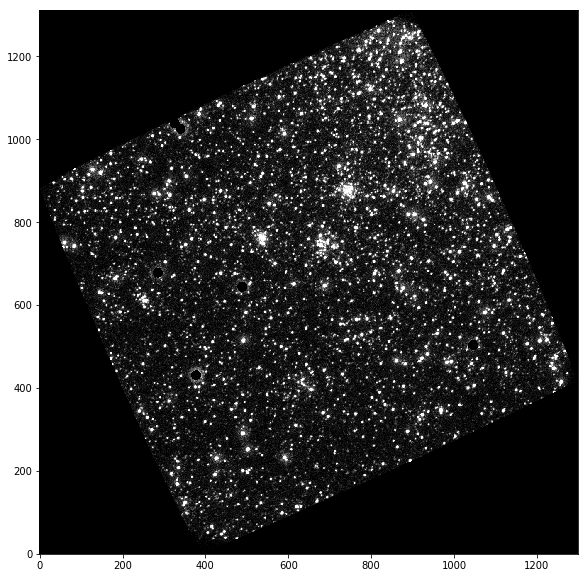

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(source.masked_data,origin='lower',vmin=0,vmax=5/60,cmap='Greys_r')

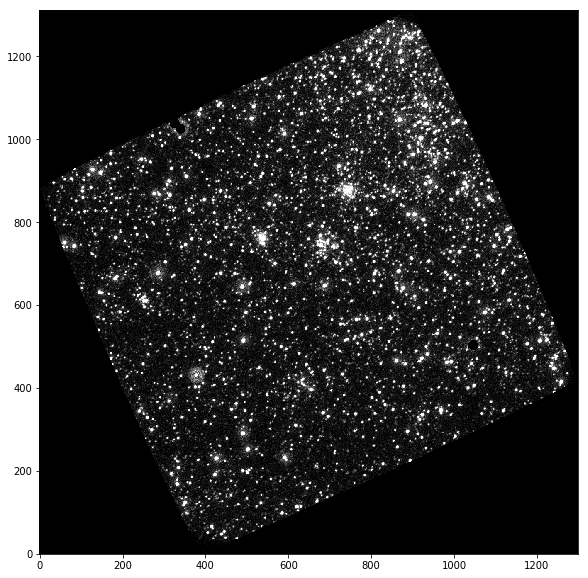

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(source.masked_byusno_data,origin='lower',vmin=0,vmax=5/60,cmap='Greys_r')

In [13]:
source.drop_cat

,ra,dec,phot,cat
52253,15.185415,-72.398530,72.622194,MCPS
59243,15.289245,-72.457890,88.835762,MCPS
64719,15.372915,-72.388820,69.206661,MCPS
20458,14.671767,-72.437627,68.825562,USNO
23085,15.320811,-72.291984,79.893713,USNO
23087,15.333913,-72.288385,72.806102,USNO


In [ ]:
en